## *Implementing AlexNet Paper*

Before that I explored reasons where it is different from a traditional Neural Net and what ingeuine tricks that they have implemented.

1. Use of *filters efficiently* to capture **spatial data** ie., it understood surroundings more efficiently. Also the use of *Max Pooling* where previous papers used average pooling, gave an edge to take the most important pixels or in other words not get smoother and blurrier features buth rather sharper and precise features
2. It used *ReLU activation* function instead of Sigmoid/tanh. This helps in convergence faster than the others because it doesnt suffer from **Vanishing gradients.**
3. It also used *Data Augmentation* like applying Image translations, reflections, tranlations, cropping etc. This increases the **generalization capabilites** of the Neural Net.
4. One more subtle and important invention was *Dropout*. Instead of standard L2 Regularization they used dropout technique, that randomly dropouts Neurons with probabililty of 0.5 assigned to every neuron. THis **prevents overfitting**. Indirectly this **reduces neurons to be dependent**(Often Termed as Co-Adaptation) on others(Interdependencies) and rather generalize and understand better themselves.

***Below is an Image of the architecture which we will be trying to implement***

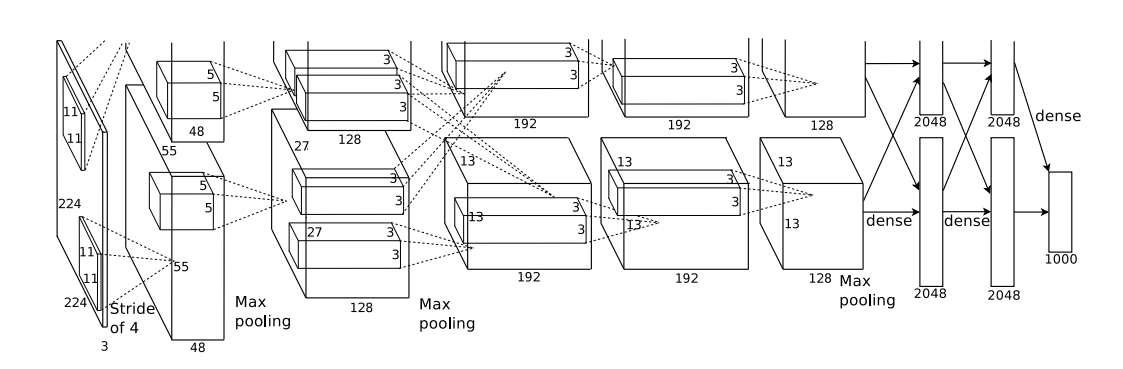

### *Defining the AlexNet Framework*

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(5),  # LRN

            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(5),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),  # conv3
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),  # conv4
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # conv5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),  # FC1
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),  # FC2
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)  # FC3
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)  # Flatten
        x = self.classifier(x)
        return x


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Transform: Resize to 224x224 and convert grayscale to 3-channel
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # AlexNet expects 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. Load Fashion-MNIST
train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.4MB/s]


In [4]:
# 4. Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [5]:
# 5. Training loop
epochs = 10
train_acc_list, val_acc_list = [], []

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_acc_list.append(train_acc)

    # Validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

Epoch 1/10: Train Acc = 0.7657, Val Acc = 0.8602
Epoch 2/10: Train Acc = 0.8829, Val Acc = 0.8899
Epoch 3/10: Train Acc = 0.9013, Val Acc = 0.9007
Epoch 4/10: Train Acc = 0.9135, Val Acc = 0.9160
Epoch 5/10: Train Acc = 0.9220, Val Acc = 0.9104
Epoch 6/10: Train Acc = 0.9295, Val Acc = 0.9119
Epoch 7/10: Train Acc = 0.9352, Val Acc = 0.9228
Epoch 8/10: Train Acc = 0.9419, Val Acc = 0.9257
Epoch 9/10: Train Acc = 0.9449, Val Acc = 0.9271
Epoch 10/10: Train Acc = 0.9513, Val Acc = 0.9319


In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Gather predictions and labels
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds)
all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)


### *Evalution of Results*

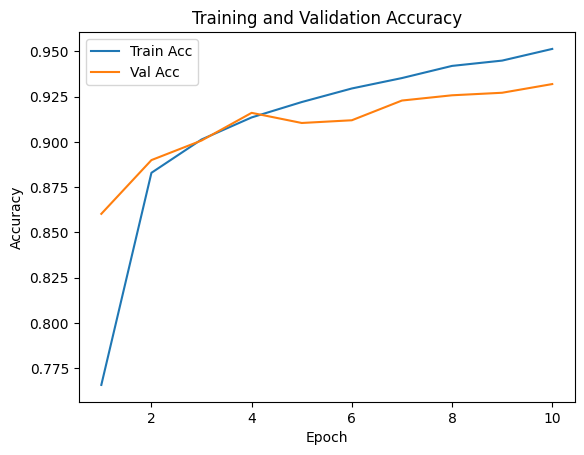

In [7]:
# 6. Plot accuracy
plt.plot(range(1, epochs+1), train_acc_list, label="Train Acc")
plt.plot(range(1, epochs+1), val_acc_list, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

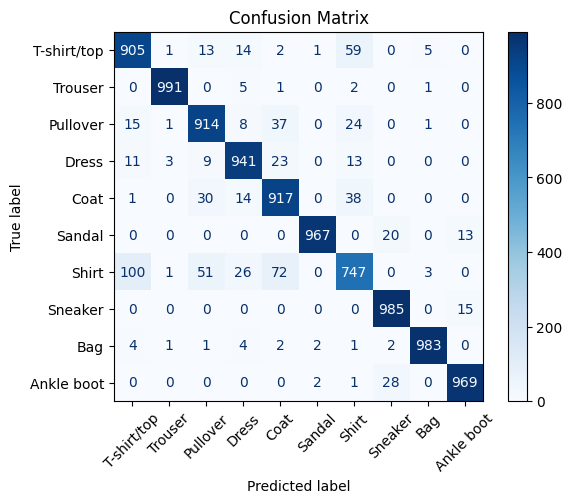

In [8]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


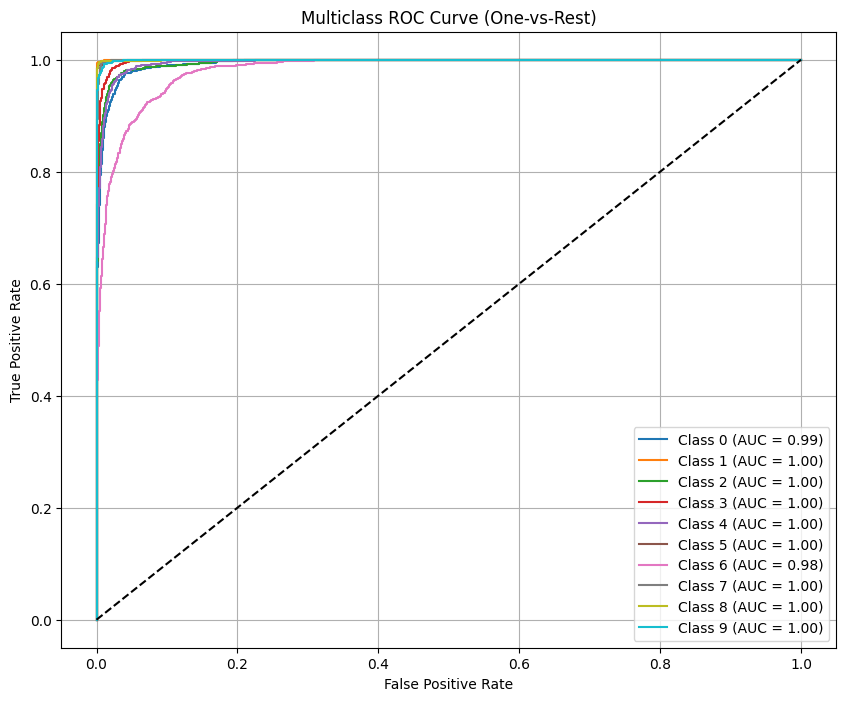

In [9]:
# Binarize true labels
y_true_bin = label_binarize(all_labels.numpy(), classes=range(10))  # shape: (n_samples, 10)
y_score = all_probs.numpy()

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid()
plt.show()
